# Main

config_bit.py loaded
Начальное количество записей (Stepstone): 2016
После удаления записей старше 6 месяцев:  1966
После удаления дубликатов (полных и по ключам: job_title, company, location): 1387


100%|████████████████████████████████████████████████████████████████████████████| 1387/1387 [00:01<00:00, 1022.24it/s]


Диаграмма 'Stepstone:Распределение вакансий по уровням опыта' сохранена: report\01_Stepstone_experience_distribution.png
Количество записей после фильтрации по [{'Not Applicable', '3+ years', 'Executive', 'Mid-Senior level', 'Director'}]: 1341
Диаграмма 'Stepstone_распределение вакансий по уровням опыта для JUNIOR LEVEL' сохранена: report\02_Stepstone_experience_distribution_junior-levels.png
Диаграмма распределения вакансий сохранена: report\03_Stepstone_vacancy_distribution.png


C:\Users\fmikh\AppData\Local\Temp\ipykernel_24708\1206044070.py:166: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\fmikh\AppData\Local\Temp\ipykernel_24708\1206044070.py:167: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Результирующий файл в формате Excel сохранён: result\Stepstone_clean_vacancies_res.xlsx


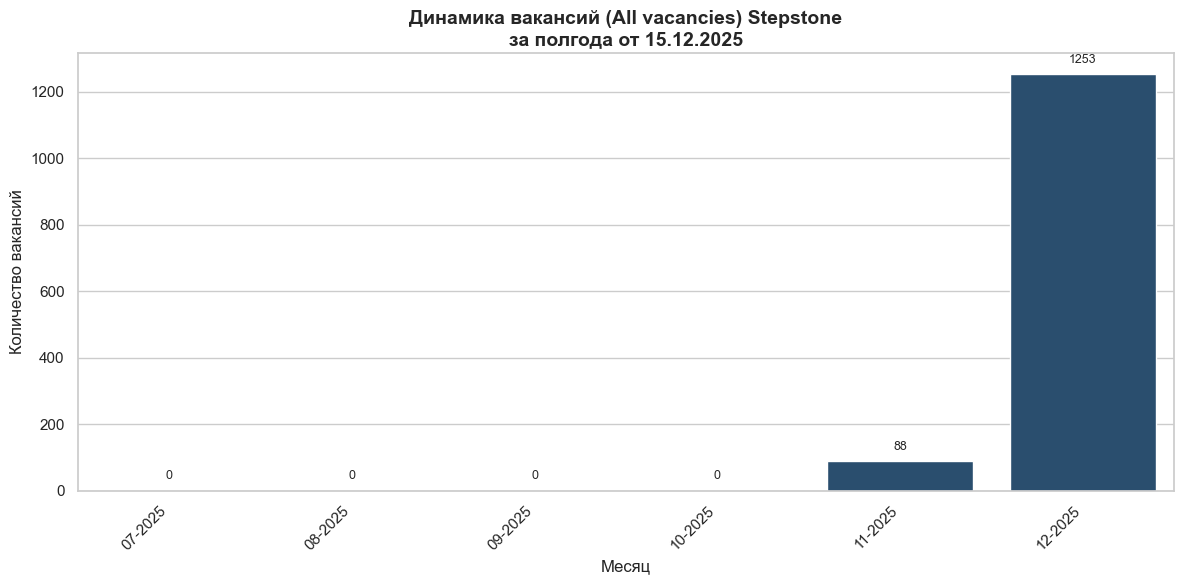

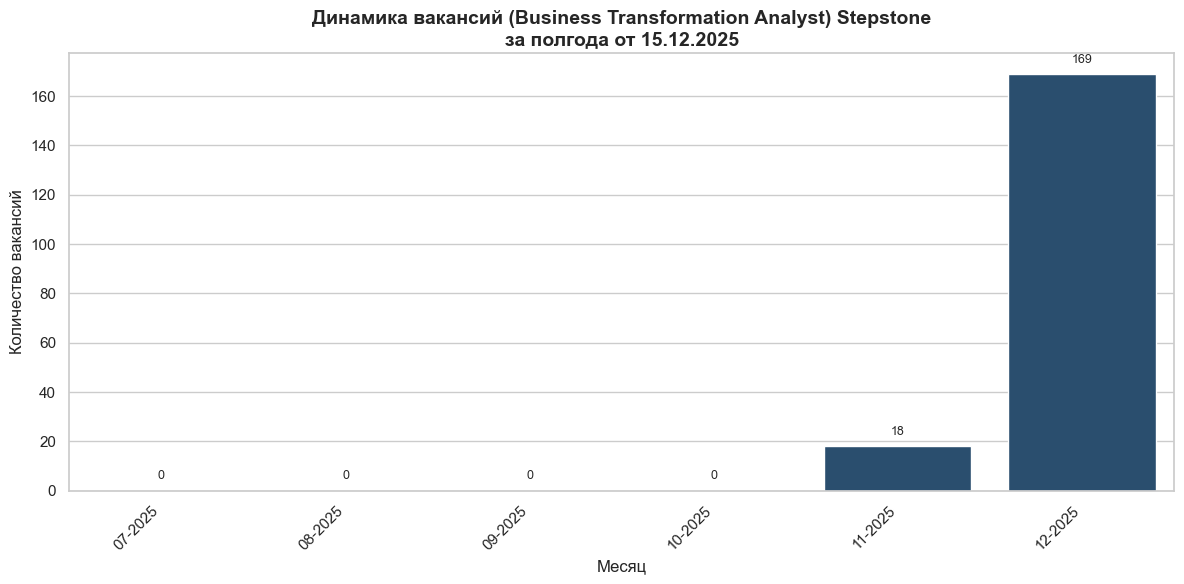

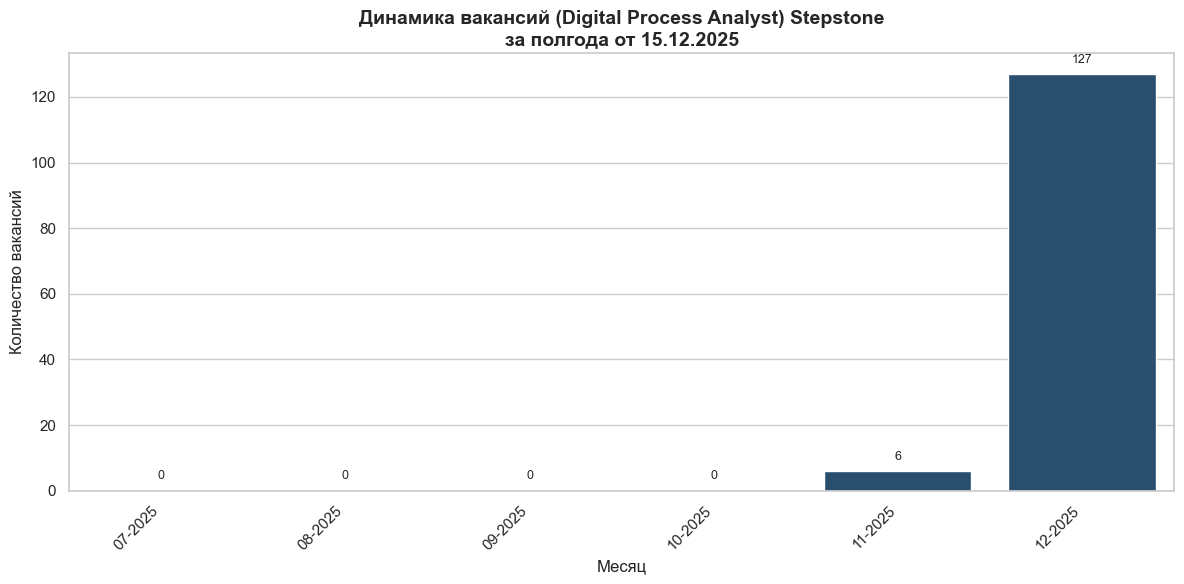

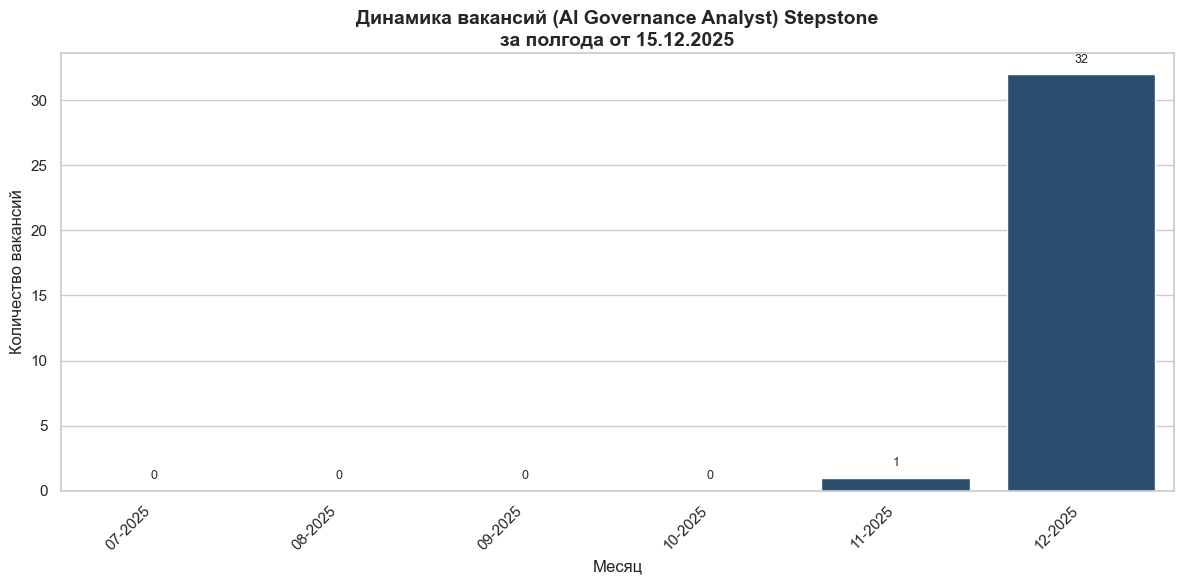

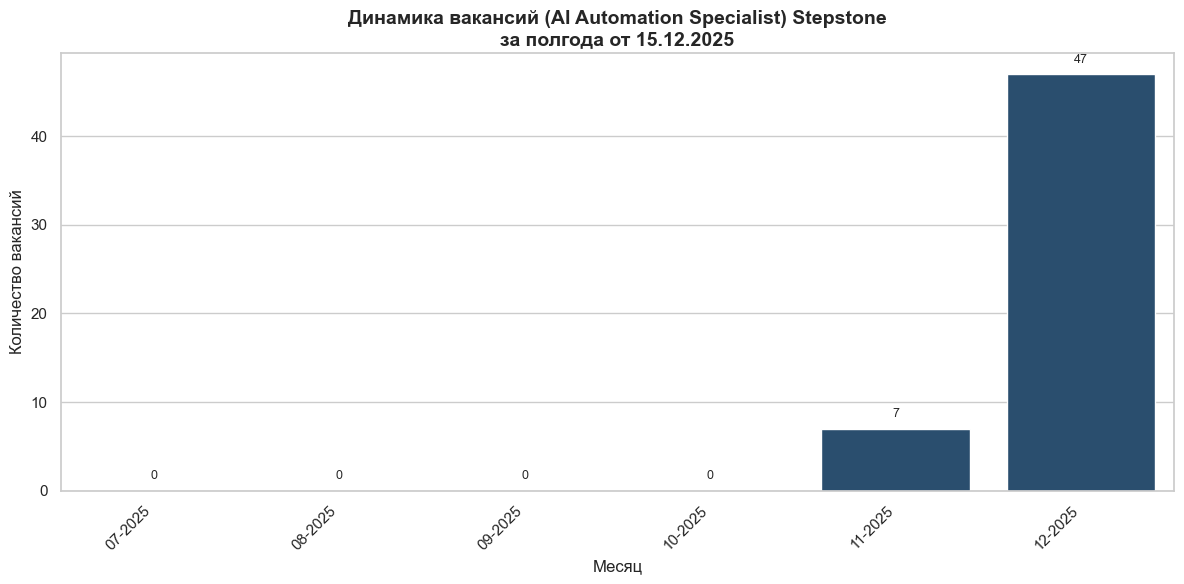

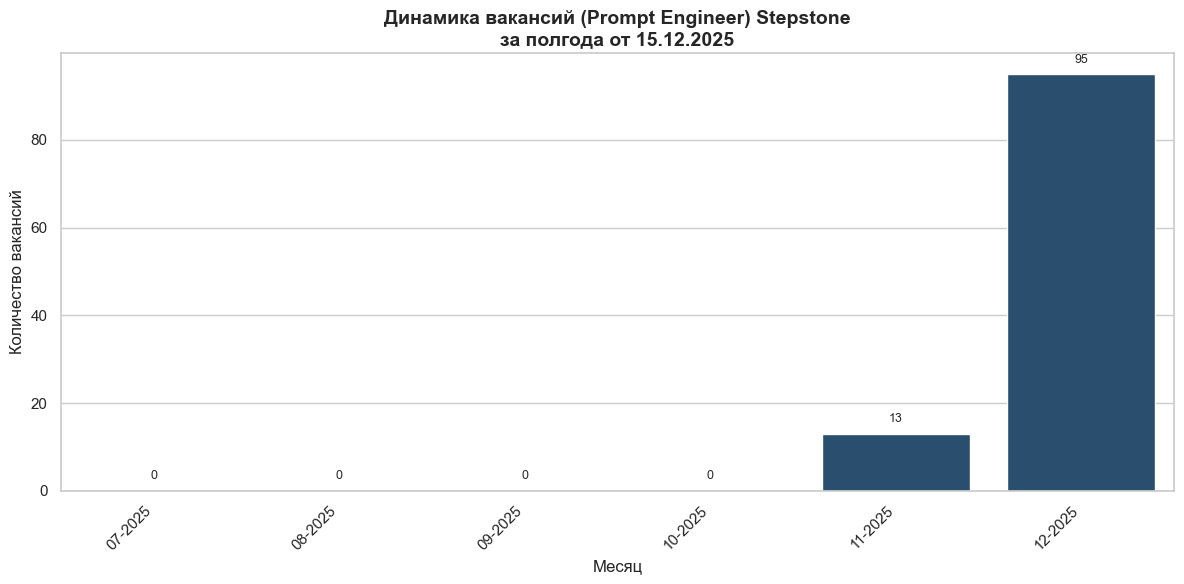

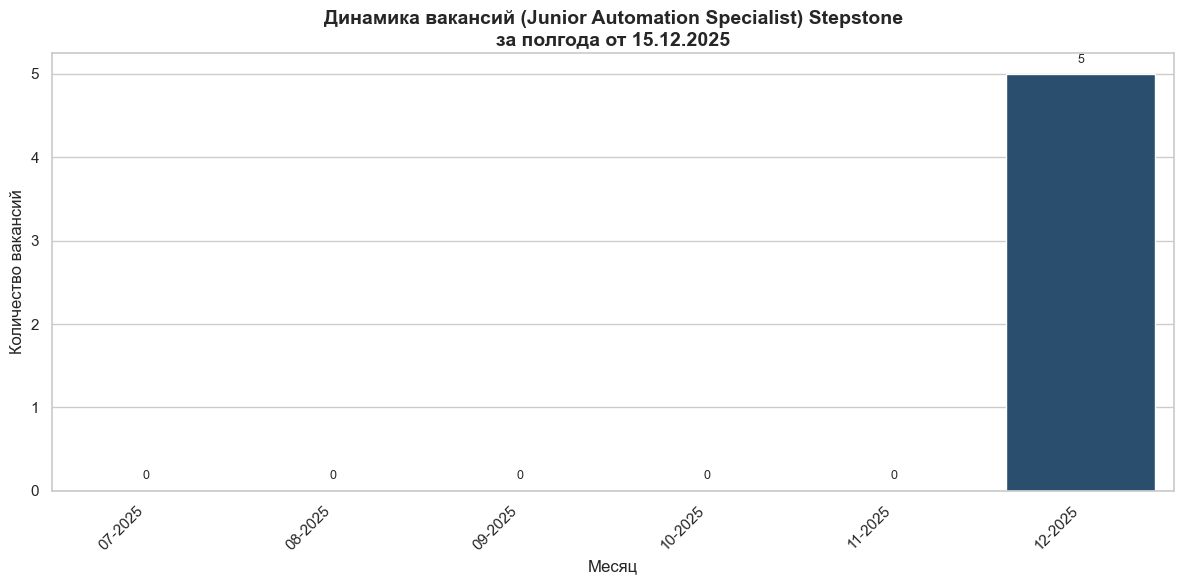

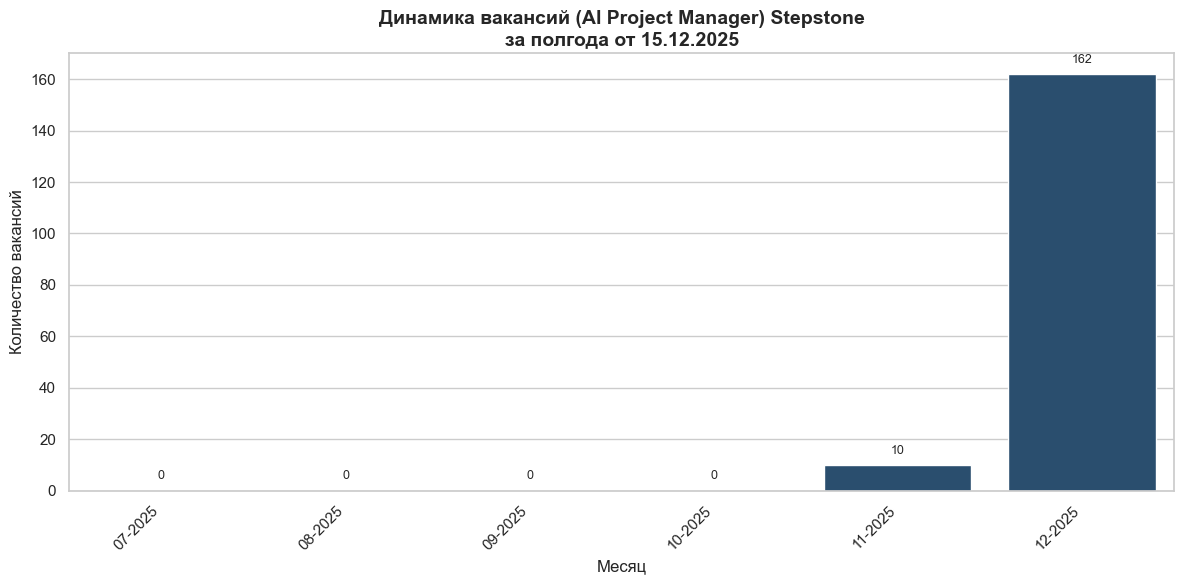

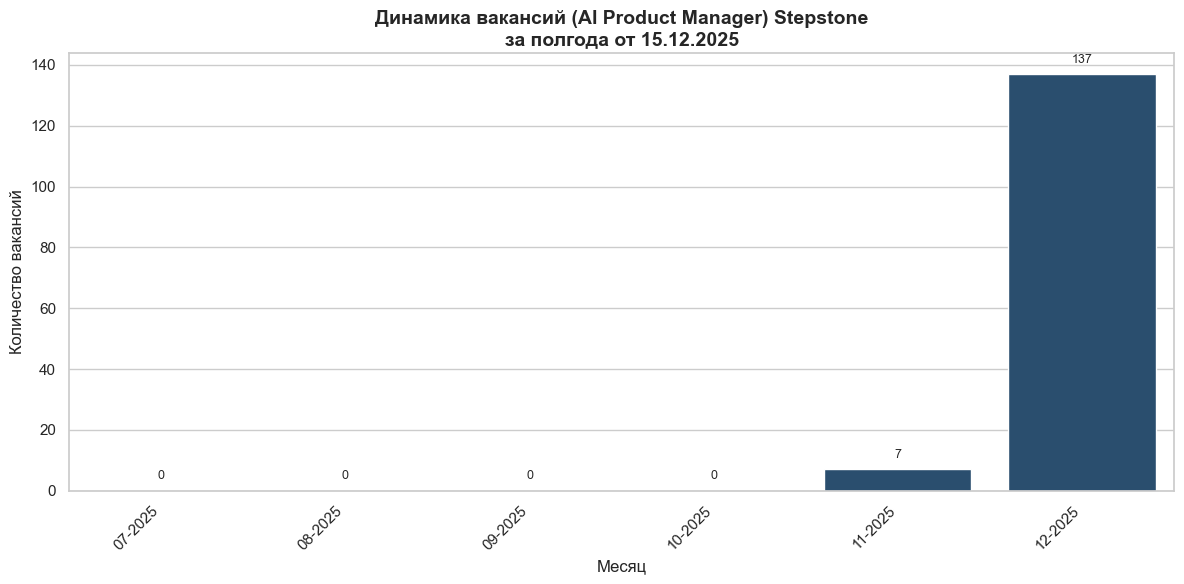

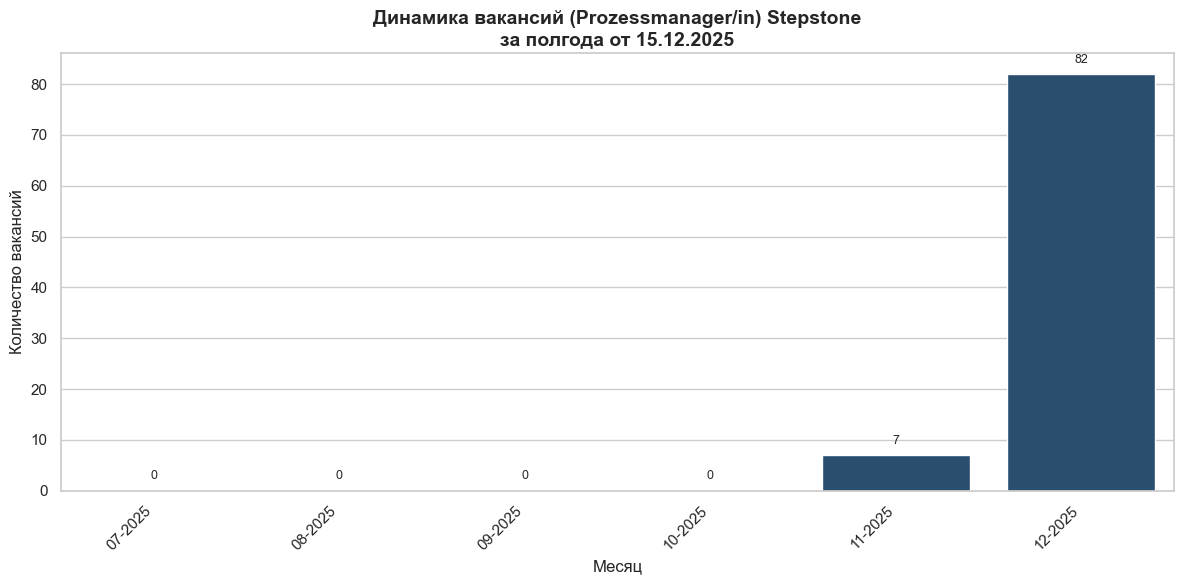

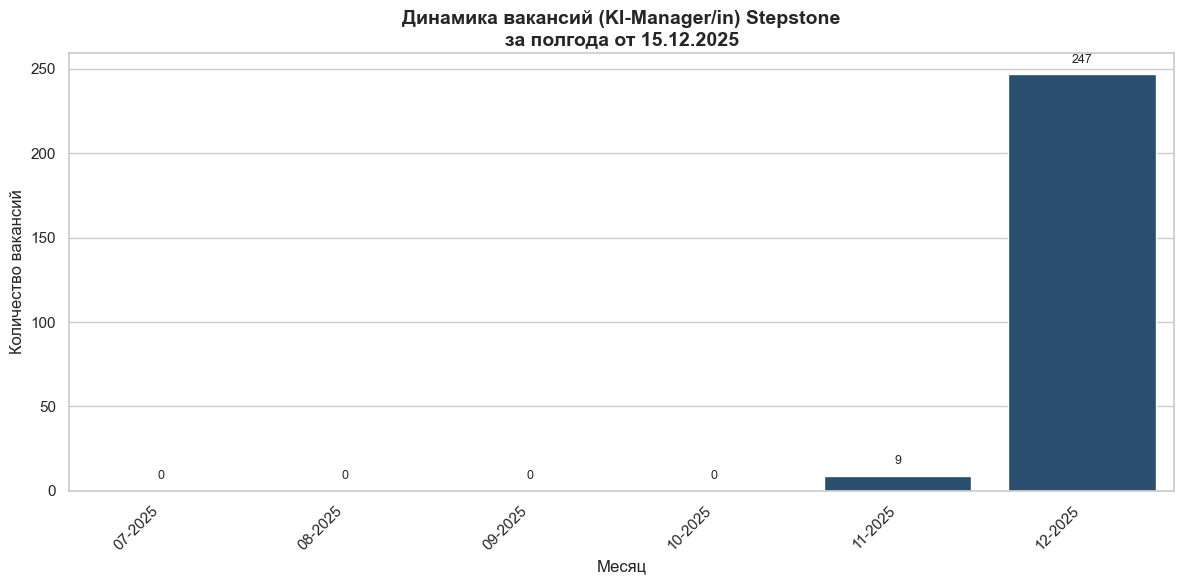

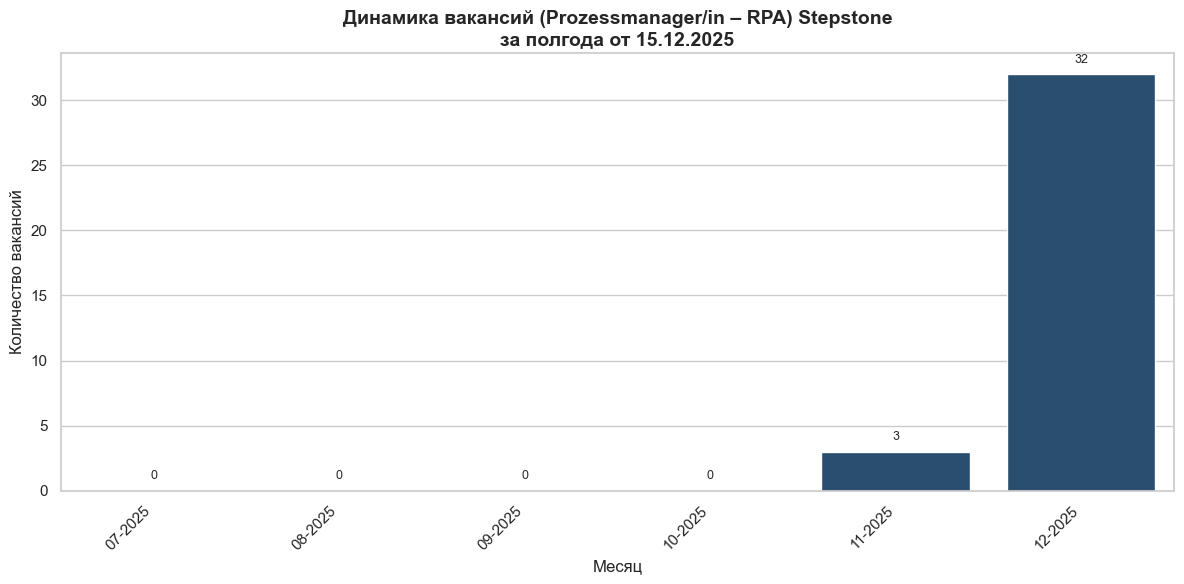

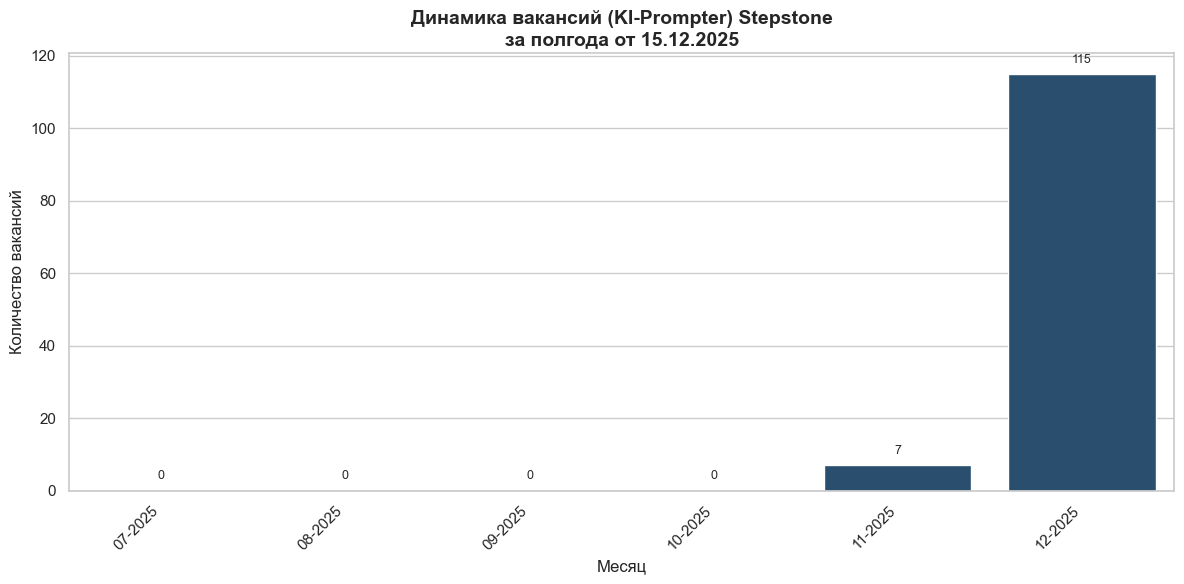

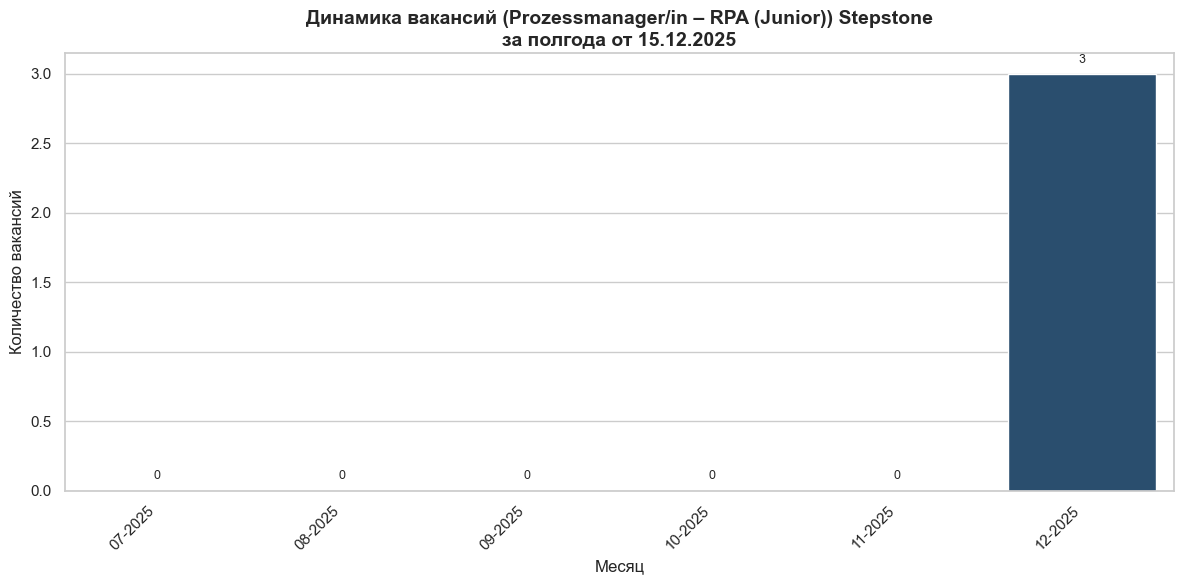

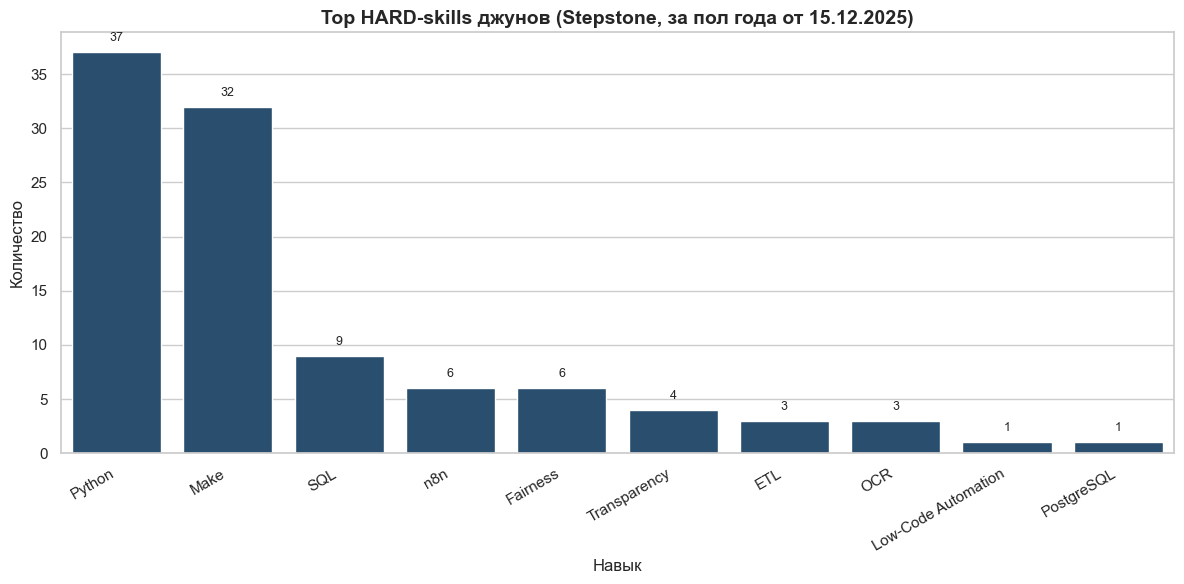

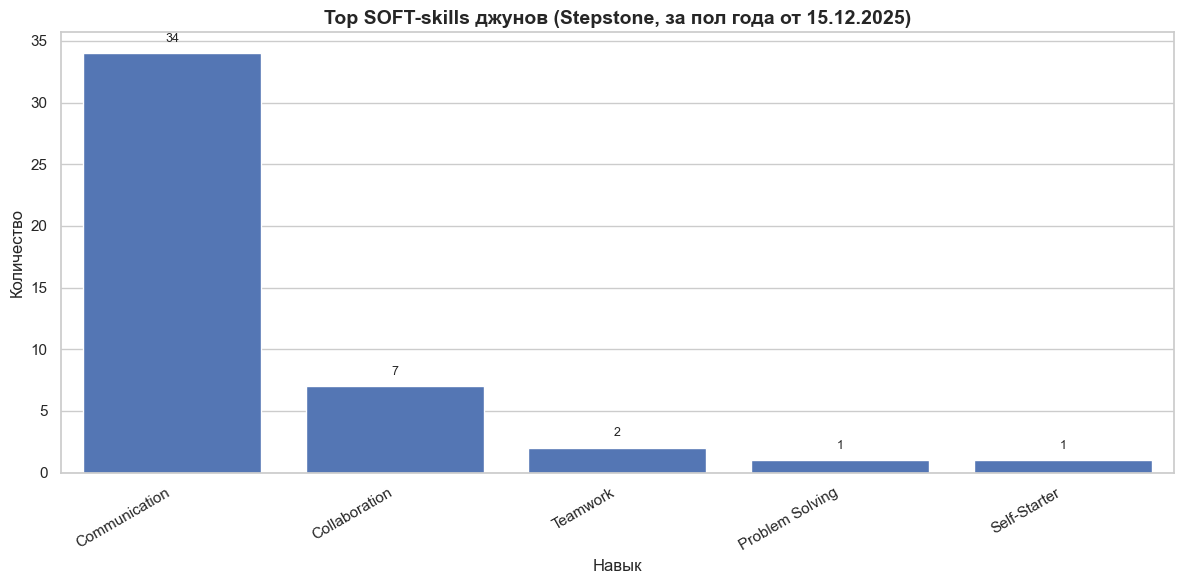

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta
from dotenv import load_dotenv
from pathlib import Path

import importlib

from tqdm import tqdm
tqdm.pandas()

from rapidfuzz import fuzz

import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from openpyxl.drawing.image import Image


import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"   # или "notebook_connected"
"""
Альтернативы:
"notebook" — встроенный рендерер, работает в JupyterLab/Notebook.
"notebook_connected" — то же самое, но с подключением к CDN.
"iframe" — вставляет график как iframe.
"browser" — открывает график во внешнем браузере.
"""


import func_bit as mvf
import config_bit as cfg

import func_bit as mvf  # Project-specific functions
import importlib

importlib.reload(mvf)

# Загрузка переменных окружения
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

# Создание папок
cfg.REPORT_FOLDER.mkdir(exist_ok=True)
cfg.RESULT_FOLDER.mkdir(exist_ok=True)

# Настройки pandas
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)

# ========================== 1. Загружаем Excel напрямую в DataFrame === 
if cfg.SCRAPING_SYST_NAME == "LinkedIn":
    file_path = Path("data") / "dataset_linkedin-jobs-scraper-no-login-required_2025-12-14.xlsx"
    df = pd.read_excel(file_path)

    df = df.rename(columns={
        "company_name": "company",
        "description_text": "description",
        "employment_type": "contractType",
        "seniority_level": "experienceLevel"
    })

    df["posted_at"] = df["published_at"].apply(mvf.parse_date)
    df = df[df["posted_at"].notna()]

elif cfg.SCRAPING_SYST_NAME == "Stepstone":
    file_path = Path("data") / "dataset_stepstone-scraper-fast-reliable-4-1k_2025-12-15_19-18-23-513.xlsx"
    df = pd.read_excel(file_path)
    df = df.rename(columns={ 
        "title":"job_title", 
        "url":"job_url", 
        "companyProfileUrl":"company_url",
        "salary":"salary_range"
    })
    
    # Приводим posted_at к timezone-naive
    df["posted_at"] = pd.to_datetime(df["datePostedISO"], errors="coerce")
    df["posted_at"] = df["posted_at"].dt.tz_localize(None)


print(f"Начальное количество записей ({cfg.SCRAPING_SYST_NAME}): {len(df)}")

# ========================== 3. Фильтрация по дате (последние 6 месяцев) ===
six_months_ago = cfg.SCRAPING_DATE - timedelta(days=180)
df = df[df["posted_at"].notna() & (df["posted_at"] >= six_months_ago)]
print("После удаления записей старше 6 месяцев: ", len(df))

# ========================== 4. Удаление дубликатов ===
df = df.drop_duplicates() \
       .drop_duplicates(subset=["job_title", "company", "location"], keep="first")
print(f"После удаления дубликатов (полных и по ключам: job_title, company, location): {len(df)}")

# ========================== 5.Визуализация распределения записей по experienceLevel 
title_prefix = "LinkedIn" if cfg.SCRAPING_SYST_NAME == "LinkedIn" else "Stepstone"

if cfg.SCRAPING_SYST_NAME == "Stepstone":
    df["experienceLevel"] = df.apply(
        lambda row: mvf.extract_experience(
            text=f"{row.get('title', '')} {row.get('description', '')}",
            experienceLevel=row.get("employmentType", "")
        ),
        axis=1
    )

    df_results = df.progress_apply(mvf.classify_soft, axis=1)
    df = pd.concat([df, df_results], axis=1)


fig = mvf.plot_experience_distribution_seaborn(
    df,
    cfg.REPORT_FOLDER,
    f"01_{title_prefix}_experience_distribution.png",
    f"{title_prefix}:Распределение вакансий по уровням опыта",
    cfg.SCRAPING_SYST_NAME
)
#fig.show()


# # ========================== 4. Фильтрация по experienceLevel ===
EXCLUDE_LEVELS = {"Executive","Director","Mid-Senior level", "Not Applicable", "3+ years"}
df_clean = df[~df["experienceLevel"].isin(EXCLUDE_LEVELS)].copy()
print(f"Количество записей после фильтрации по [{EXCLUDE_LEVELS}]: {len(df_clean)}")

chart_file_name = f"02_{cfg.SCRAPING_SYST_NAME}_experience_distribution_junior-levels.png"
chart_name = f"{cfg.SCRAPING_SYST_NAME}_распределение вакансий по уровням опыта для JUNIOR LEVEL"

fig = mvf.plot_experience_distribution_seaborn(
    df_clean,
    cfg.REPORT_FOLDER,
    chart_file_name,
    chart_name,
    cfg.SCRAPING_SYST_NAME
)
#fig.show()


# # ========================== 5. Очистка job_title ===
df_clean["job_title_clean"] = mvf.clean_job_titles(df_clean["job_title"].tolist())


# # ========================== 7. диаграмма распределения вакансий по search_term ===
fig = mvf.plot_vacancy_distribution_seaborn(df_clean, cfg.JOB_TITLE, cfg.SCRAPING_SYST_NAME, cfg.REPORT_FOLDER)
#fig.show()

# ========================== 8. динамика вакансий
mvf.plot_vacancy_dynamics_separate_seaborn(
    df_clean,
    cfg.JOB_TITLE,
    six_months_ago,
    cfg.SCRAPING_DATE,
    cfg.SCRAPING_SYST_NAME
)

# ========================== 9. анализ скиллов джунов
# список уровней из датафрейма
entry_level_list = df_clean["experienceLevel"].unique().tolist()
hard_counter, soft_counter = mvf.analyze_skills_by_levels(df_clean,entry_level_list, cfg.HARD_SKILLS, cfg.SOFT_SKILLS)

#fig = mvf.plot_junior_skills_interactive(hard_counter, soft_counter, cfg.SCRAPING_DATE, cfg.REPORT_FOLDER, cfg.SCRAPING_SYST_NAME)
#fig.show()

fig_hard, fig_soft = mvf.plot_junior_skills_separate_seaborn(hard_counter, soft_counter, cfg.SCRAPING_DATE, cfg.SCRAPING_SYST_NAME)
fig_hard.show()
fig_soft.show()

# ========================== 6. Сохранение результата ===
# Список нужных колонок
cols = [
    'search_term',
    'job_title',
    'job_title_clean',
    'job_url',
    'experienceLevel',
    'company',
    'company_url',
    'location',
    'posted_at',
    'salary_range',
    'description'
]

# Преобразуем posted_at в дату (без часов, минут, секунд)
df_clean['posted_at'] = pd.to_datetime(df_clean['posted_at']).dt.date

# Оставляем только указанные колонки в нужном порядке
df_clean = df_clean[cols]
output_path = cfg.RESULT_FOLDER / f"{cfg.SCRAPING_SYST_NAME}_clean_vacancies_res.xlsx"
df_clean.to_excel(output_path, index=False)
print(f"Результирующий файл в формате Excel сохранён: {output_path}")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1387 entries, 0 to 2014
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   applicationTypes/0  322 non-null    object        
 1   applicationTypes/1  4 non-null      object        
 2   company             1387 non-null   object        
 3   companyLogoUrl      1387 non-null   object        
 4   company_url         1387 non-null   object        
 5   datePosted          1387 non-null   object        
 6   datePostedISO       1387 non-null   object        
 7   description         1386 non-null   object        
 8   employmentType      339 non-null    object        
 9   isNew               1387 non-null   bool          
 10  isRemote            903 non-null    object        
 11  jobId               1387 non-null   int64         
 12  location            1387 non-null   object        
 13  salary_range        0 non-null      float64       
 1

# REPORT

In [2]:
import re
from pathlib import Path

report_folder = cfg.REPORT_FOLDER
report_path = report_folder / "full_report.html"

charts = [
    "01_experience_distribution_all-levels.html",
    "02_experience_distribution_junior-levels.html",
    "03_vacancy_distribution.html",
    "04_vacancies_dynamics.html",
    "05_junior_skills_interactive.html"
]

# --- функция для description ---
def first_sentence(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return ""
    clean_text = text.strip()
    return (clean_text[:250] + "...") if len(clean_text) > 250 else clean_text

# --- формируем таблицу примеров вакансий ---
df_sample = df_clean.groupby("search_term", as_index=False).first().copy()
df_sample["description"] = df_sample["description"].apply(first_sentence)

# делаем job_url гиперссылкой
def make_link(url: str) -> str:
    if not isinstance(url, str) or not url.strip():
        return ""
    return f'<a href="{url}" target="_blank">ссылка</a>'

df_sample["job_url"] = df_sample["job_url"].apply(make_link)

columns = ["search_term", "job_title", "company", "location",
           "experienceLevel", "published_at", "salary_range", "job_url", "description"]
df_sample = df_sample[columns]

html_table = df_sample.to_html(index=False, escape=False)
styled_table = f"""
<div class="sample-table">
{html_table}
</div>
"""

# --- текстовые блоки ---
text_block = """
<h2>Общие сведения и ход обработки</h2>
<p>Анализ вакансий проведён на основе данных LinkedIn, собранных 14 декабря 2025 года. Исходный объём — <strong>2515 записей</strong>.</p>
<ul>
  <li>После фильтрации по дате публикации (последние 6 месяцев): <strong>2462 записи</strong></li>
  <li>После удаления дубликатов (полных и по ключам: <code>job_title</code>, <code>company</code>, <code>location</code>): <strong>2205 уникальных вакансий</strong></li>
  <li>После исключения уровней опыта <code>Mid-Senior level</code>, <code>Executive</code>, <code>Director</code>, <code>Not Applicable</code>: <strong>925 записей</strong>, релевантных для junior/entry-level анализа</li>
</ul>
<p>Результирующий очищенный файл сохранён: <code>result/clean_vacancies_res.xlsx</code></p>

<h2>Ключевые выводы</h2>
<ul>
  <li><strong>Рынок вакансий для начинающих специалистов</strong> составляет около 37% от общего объёма после очистки.</li>
  <li><strong>Наиболее востребованные уровни</strong> среди джунов — <em>Entry level</em> и <em>Associate</em>, с заметным присутствием <em>Internship</em>.</li>
  <li><strong>Популярные должности</strong> включают: <em>AI Product Manager</em>, <em>AI Project Manager</em>, <em>Digital Process Analyst</em>, <em>Prozessmanager/in</em>, <em>KI-Manager/in</em>.</li>
  <li><strong>Динамика вакансий</strong> показывает резкий рост в ноябре и декабре 2025 года.</li>
  <li><strong>Топ HARD skills</strong>: <em>Make</em>, <em>SQL</em>, <em>Python</em>, <em>Fairness</em>, <em>BPMN</em>.</li>
  <li><strong>Топ SOFT skills</strong>: <em>Communication</em>, <em>Collaboration</em>, <em>Teamwork</em>, <em>Problem Solving</em>.</li>
</ul>

<h2>Рекомендации</h2>
<p>Для соискателей на junior-уровне рекомендуется фокусироваться на сочетании технических навыков (Python, SQL, визуализация, автоматизация) и развитии soft-компетенций. Работодателям — учитывать растущий интерес к ролям с гибридным профилем: AI + бизнес-процессы.</p>
"""

# --- формируем HTML ---
with open(report_path, "w", encoding="utf-8") as f:
    f.write("<!DOCTYPE html><html lang='ru'><head><meta charset='UTF-8'>")
    f.write("<title>Отчёт по вакансиям \"AI Business Automation Specialist\" в LinkedIn для Германии</title>")
    f.write("<style>body{font-family:Arial,sans-serif;margin:40px;background:#f9f9f9;color:#333;}h1,h2{color:#2c3e50;}pre{background:#eef;padding:10px;border-left:4px solid #88c;}ul{margin-left:20px;} .chart{margin:40px 0;} table{border-collapse:collapse;width:100%;margin-top:20px;} th,td{border:1px solid #ccc;padding:6px;text-align:left;} th{background:#eee;} .sample-table{font-family:'Arial Nova Cond',Arial,sans-serif;font-size:8pt;}</style>")
    f.write("</head><body>")
    f.write("<h1>Отчёт по вакансиям \"AI Business Automation Specialist\" в LinkedIn для Германии</h1>")
    f.write("<h2>Лог выполнения</h2><pre>")
    f.write("Начальное количество записей (LinkedIn): 2515\n")
    f.write("После удаления записей старше 6 месяцев: 2462\n")
    f.write("После удаления дубликатов (полных и по ключам: job_title, company, location): 2205\n")
    f.write("Количество записей после фильтрации по [{'Mid-Senior level','Not Applicable','Executive','Director'}]: 925\n")
    f.write("Результирующий файл Excel сохранён: result\\clean_vacancies_res.xlsx\n")
    f.write("</pre>")
    f.write(text_block)

    f.write("<h2>Диаграммы</h2>")
    for chart in charts:
        chart_path = report_folder / chart
        if chart_path.exists():
            with open(chart_path, "r", encoding="utf-8") as cf:
                f.write("<div class='chart'>")
                f.write(cf.read())
                f.write("</div>")

    # таблица в самом конце
    f.write("<h2>Примеры вакансий по поисковым титлам</h2>")
    f.write(styled_table)

    f.write("</body></html>")

print(f"Единый HTML отчёт собран: {report_path}")


Единый HTML отчёт собран: report\full_report.html


## PDF

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ОБЯЗАТЕЛЬНО: определяем путь к отчёту
report_folder = cfg.REPORT_FOLDER
report_folder.mkdir(exist_ok=True)
pdf_path = report_folder / "vacancies_report.pdf"

def is_kaleido_available_and_compatible():
    try:
        import plotly
        import kaleido  # noqa
        from packaging import version
        # Требование совместимости: Plotly >= 6.1.1 для Kaleido 1.2.0
        return version.parse(plotly.__version__) >= version.parse("6.1.1")
    except Exception:
        return False

def save_plotly_to_pdf(fig, pdf, temp_name, title=None):
    """Пробует сохранить plotly-график как PNG и вставить в PDF. Если экспорта нет — пропускает."""
    if not is_kaleido_available_and_compatible():
        print("Пропуск экспорта: требуется Kaleido и совместимая версия Plotly (>= 6.1.1).")
        return
    try:
        fig.write_image(temp_name)  # требует kaleido
        img = plt.imread(temp_name)
        fig_mpl, ax = plt.subplots()
        ax.imshow(img)
        ax.axis("off")
        if title:
            ax.set_title(title)
        pdf.savefig(fig_mpl)
        plt.close(fig_mpl)
    except Exception as e:
        print("Не удалось экспортировать изображение Plotly. Сообщение:", e)

with PdfPages(pdf_path) as pdf:
    # --- Текстовые разделы ---
    fig, ax = plt.subplots(figsize=(8.3, 11.7))  # формат A4
    ax.axis("off")
    text = (
        "Отчёт по вакансиям \"AI Business Automation Specialist\" в LinkedIn для Германии\n\n"
        "Лог выполнения:\n"
        "Начальное количество записей: 2515\n"
        "После удаления старше 6 месяцев: 2462\n"
        "После удаления дубликатов: 2205\n"
        "После фильтрации уровней опыта: 925\n\n"
        "Ключевые выводы:\n"
        "- Рынок вакансий для начинающих специалистов ~37%.\n"
        "- Наиболее востребованные уровни: Entry level, Associate, Internship.\n"
        "- Популярные должности: AI Product Manager, AI Project Manager, Digital Process Analyst, Prozessmanager/in, KI-Manager/in.\n"
        "- Динамика вакансий: рост в ноябре–декабре 2025.\n"
        "- Топ HARD skills: Make, SQL, Python, Fairness, BPMN.\n"
        "- Топ SOFT skills: Communication, Collaboration, Teamwork, Problem Solving.\n\n"
        "Рекомендации:\n"
        "Соискателям — развивать Python, SQL и soft skills.\n"
        "Работодателям — учитывать спрос на гибридные роли AI + бизнес-процессы."
    )
    ax.text(0.05, 0.95, text, va="top", fontsize=10, wrap=True)
    pdf.savefig(fig)
    plt.close(fig)

    # --- Диаграммы из анализа ---
    fig1 = mvf.plot_experience_distribution(
        df, cfg.REPORT_FOLDER,
        "01_experience_distribution_all-levels.html",
        "Распределение вакансий по уровням опыта до фильтрации"
    )
    save_plotly_to_pdf(fig1, pdf, "temp1.png")

    fig2 = mvf.plot_experience_distribution(
        df_clean, cfg.REPORT_FOLDER,
        "02_experience_distribution_junior-levels.html",
        "Распределение вакансий по уровням опыта после фильтрации для JUNIOR LEVEL"
    )
    save_plotly_to_pdf(fig2, pdf, "temp2.png")

    fig3 = mvf.plot_vacancy_distribution(
        df_clean, cfg.JOB_TITLE, cfg.SCRAPING_SYST_NAME, cfg.REPORT_FOLDER
    )
    save_plotly_to_pdf(fig3, pdf, "temp3.png")

    # Важно: если ранее была ошибка сравнения дат, убедись, что posted_at — Timestamp
    # df_clean["posted_at"] = pd.to_datetime(df_clean["posted_at"])

    figs_dyn = mvf.plot_vacancy_dynamics_separate(
        df_clean, cfg.JOB_TITLE, six_months_ago, cfg.SCRAPING_DATE, cfg.SCRAPING_SYST_NAME
    )
    for term, fig_dyn in figs_dyn.items():
        save_plotly_to_pdf(fig_dyn, pdf, f"temp_dyn_{term}.png", title=f"Динамика вакансий: {term}")

    fig_hard, fig_soft = mvf.plot_junior_skills_separate(
        hard_counter, soft_counter, cfg.SCRAPING_DATE, cfg.SCRAPING_SYST_NAME
    )
    save_plotly_to_pdf(fig_hard, pdf, "temp_hard.png")
    save_plotly_to_pdf(fig_soft, pdf, "temp_soft.png")

print(f"PDF-отчёт сохранён: {pdf_path}")


Диаграмма 'Распределение вакансий по уровням опыта до фильтрации' сохранена: report\01_experience_distribution_all-levels.html
Диаграмма 'Распределение вакансий по уровням опыта после фильтрации для JUNIOR LEVEL' сохранена: report\02_experience_distribution_junior-levels.html
Интерактивная диаграмма распределения вакансий по поисковым титлам сохранена в: report\03_vacancy_distribution.html


Не удалось экспортировать изображение Plotly. Сообщение: [Errno 2] No such file or directory: 'temp_dyn_Prozessmanager\\in.png'
Не удалось экспортировать изображение Plotly. Сообщение: [Errno 2] No such file or directory: 'temp_dyn_KI-Manager\\in.png'
Не удалось экспортировать изображение Plotly. Сообщение: [Errno 2] No such file or directory: 'temp_dyn_Prozessmanager\\in – RPA.png'
Не удалось экспортировать изображение Plotly. Сообщение: [Errno 2] No such file or directory: 'temp_dyn_Prozessmanager\\in – RPA (Junior).png'
PDF-отчёт сохранён: report\vacancies_report.pdf
